In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.metrics import (roc_auc_score, average_precision_score, confusion_matrix,
                             classification_report, roc_curve, precision_recall_curve)
from sklearn.calibration import calibration_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [3]:
import xgboost as xgb
import shap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [4]:
import joblib
import json
from tqdm import tqdm
import scipy.stats as stats

In [5]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")
%matplotlib inline

In [6]:
np.random.seed(42)

In [9]:
print("Loading data...")
patients_df = pd.read_csv('patients.csv')
historical_df = pd.read_csv('historical_data.csv')
outcomes_df = pd.read_csv('outcomes.csv')

Loading data...


In [8]:
historical_df['date'] = pd.to_datetime(historical_df['date'])
outcomes_df['index_date'] = pd.to_datetime(outcomes_df['index_date'])

In [10]:
print("Data loaded successfully!")
print(f"Patients: {len(patients_df)}")
print(f"Historical records: {len(historical_df)}")
print(f"Outcomes with deterioration: {outcomes_df['deterioration_label'].sum()}")

Data loaded successfully!
Patients: 5000
Historical records: 7305000
Outcomes with deterioration: 1685


In [11]:
print("Patient Demographics Overview:")
print(patients_df.describe())

Patient Demographics Overview:
               age    height_cm  baseline_weight_kg  baseline_bmi  \
count  5000.000000  5000.000000         5000.000000   5000.000000   
mean     61.747600   168.479540           78.634900     27.841460   
std      13.784509     9.125733           15.881732      5.401896   
min      25.000000   141.900000           21.100000     18.000000   
25%      52.000000   161.600000           67.800000     23.900000   
50%      62.000000   168.000000           78.350000     27.600000   
75%      71.000000   175.000000           89.000000     31.400000   
max      95.000000   206.400000          138.800000     49.800000   

       baseline_systolic_bp  baseline_diastolic_bp  baseline_hba1c  \
count           5000.000000            5000.000000     5000.000000   
mean             141.119800              86.106000        6.743140   
std               16.145587              10.110114        1.319734   
min               90.000000              60.000000        4.500000 

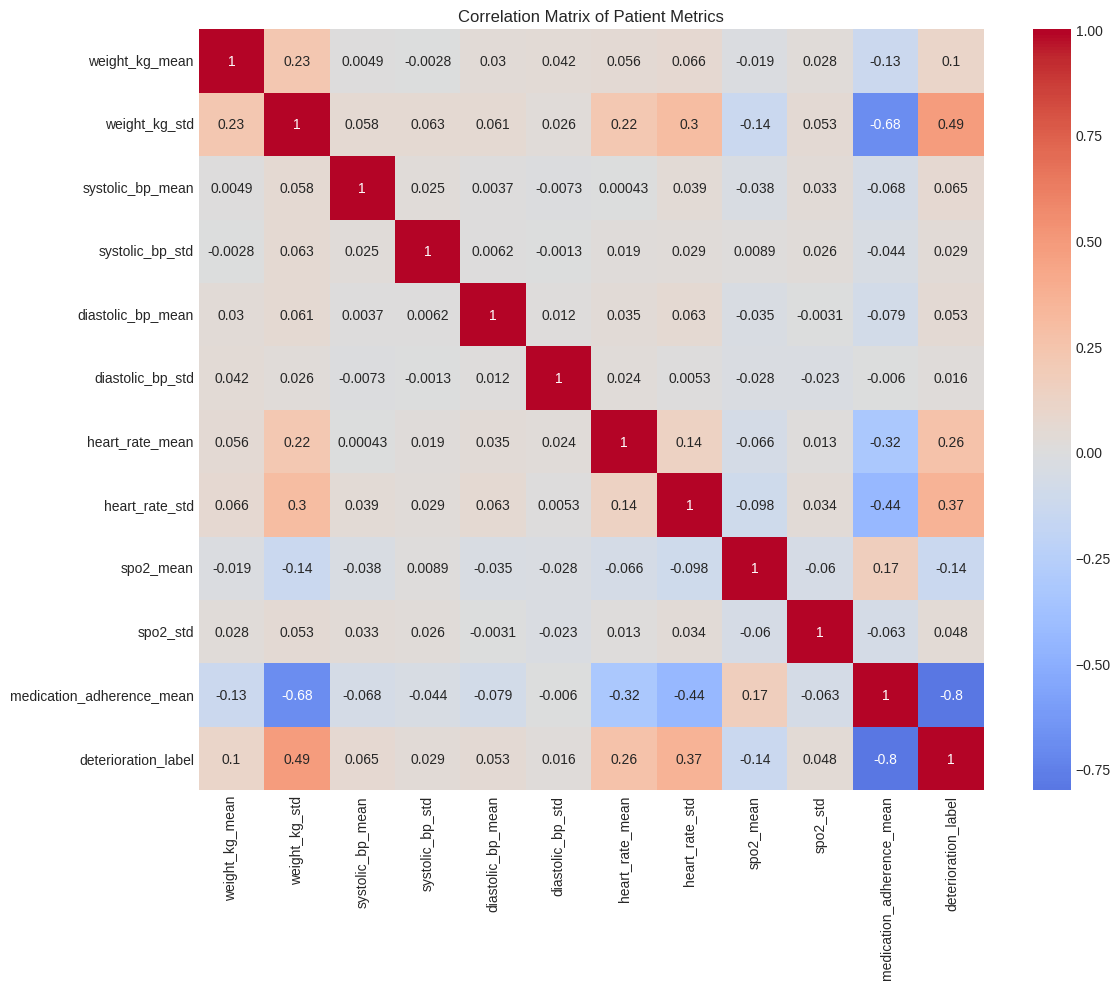

In [34]:
# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Patient Metrics')
plt.tight_layout()
plt.show()

Patient Demographics Overview:
               age    height_cm  baseline_weight_kg  baseline_bmi  \
count  5000.000000  5000.000000         5000.000000   5000.000000   
mean     61.747600   168.479540           78.634900     27.841460   
std      13.784509     9.125733           15.881732      5.401896   
min      25.000000   141.900000           21.100000     18.000000   
25%      52.000000   161.600000           67.800000     23.900000   
50%      62.000000   168.000000           78.350000     27.600000   
75%      71.000000   175.000000           89.000000     31.400000   
max      95.000000   206.400000          138.800000     49.800000   

       baseline_systolic_bp  baseline_diastolic_bp  baseline_hba1c  \
count           5000.000000            5000.000000     5000.000000   
mean             141.119800              86.106000        6.743140   
std               16.145587              10.110114        1.319734   
min               90.000000              60.000000        4.500000 

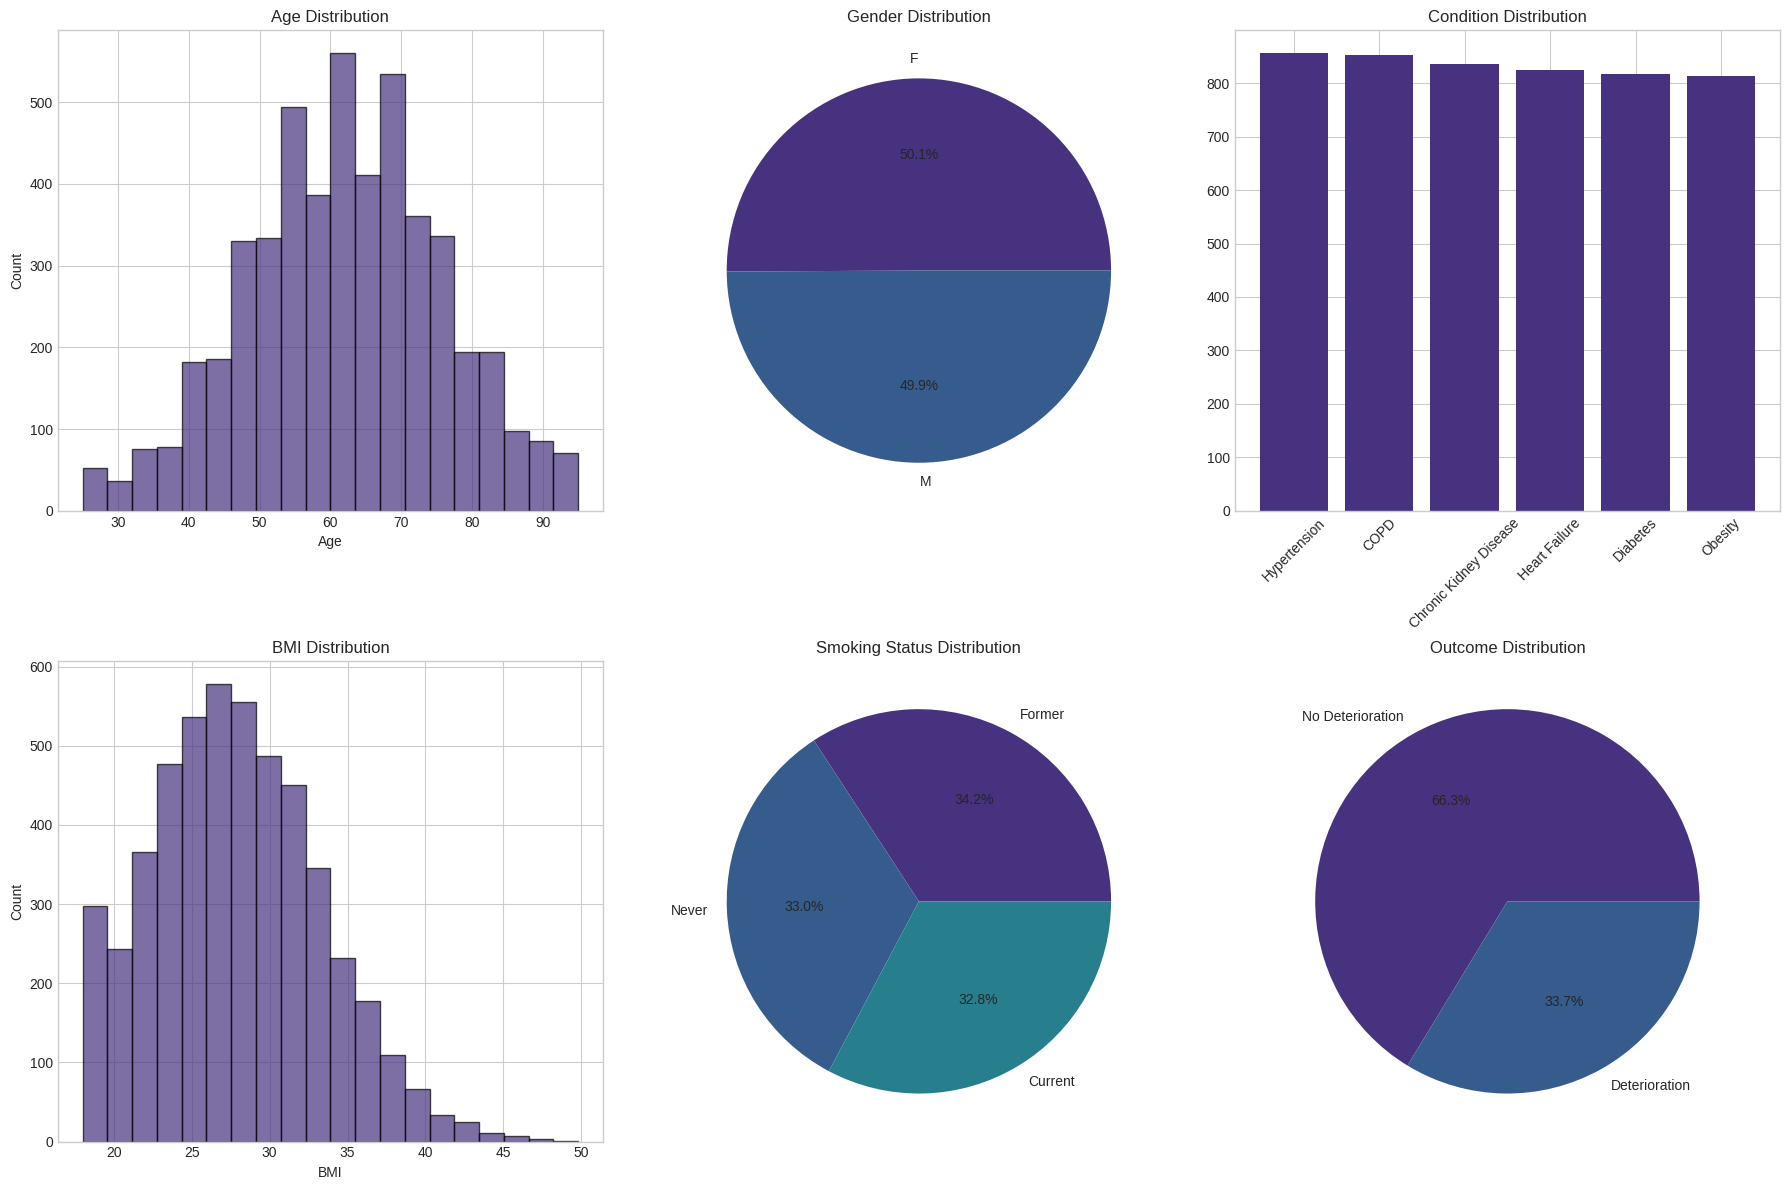

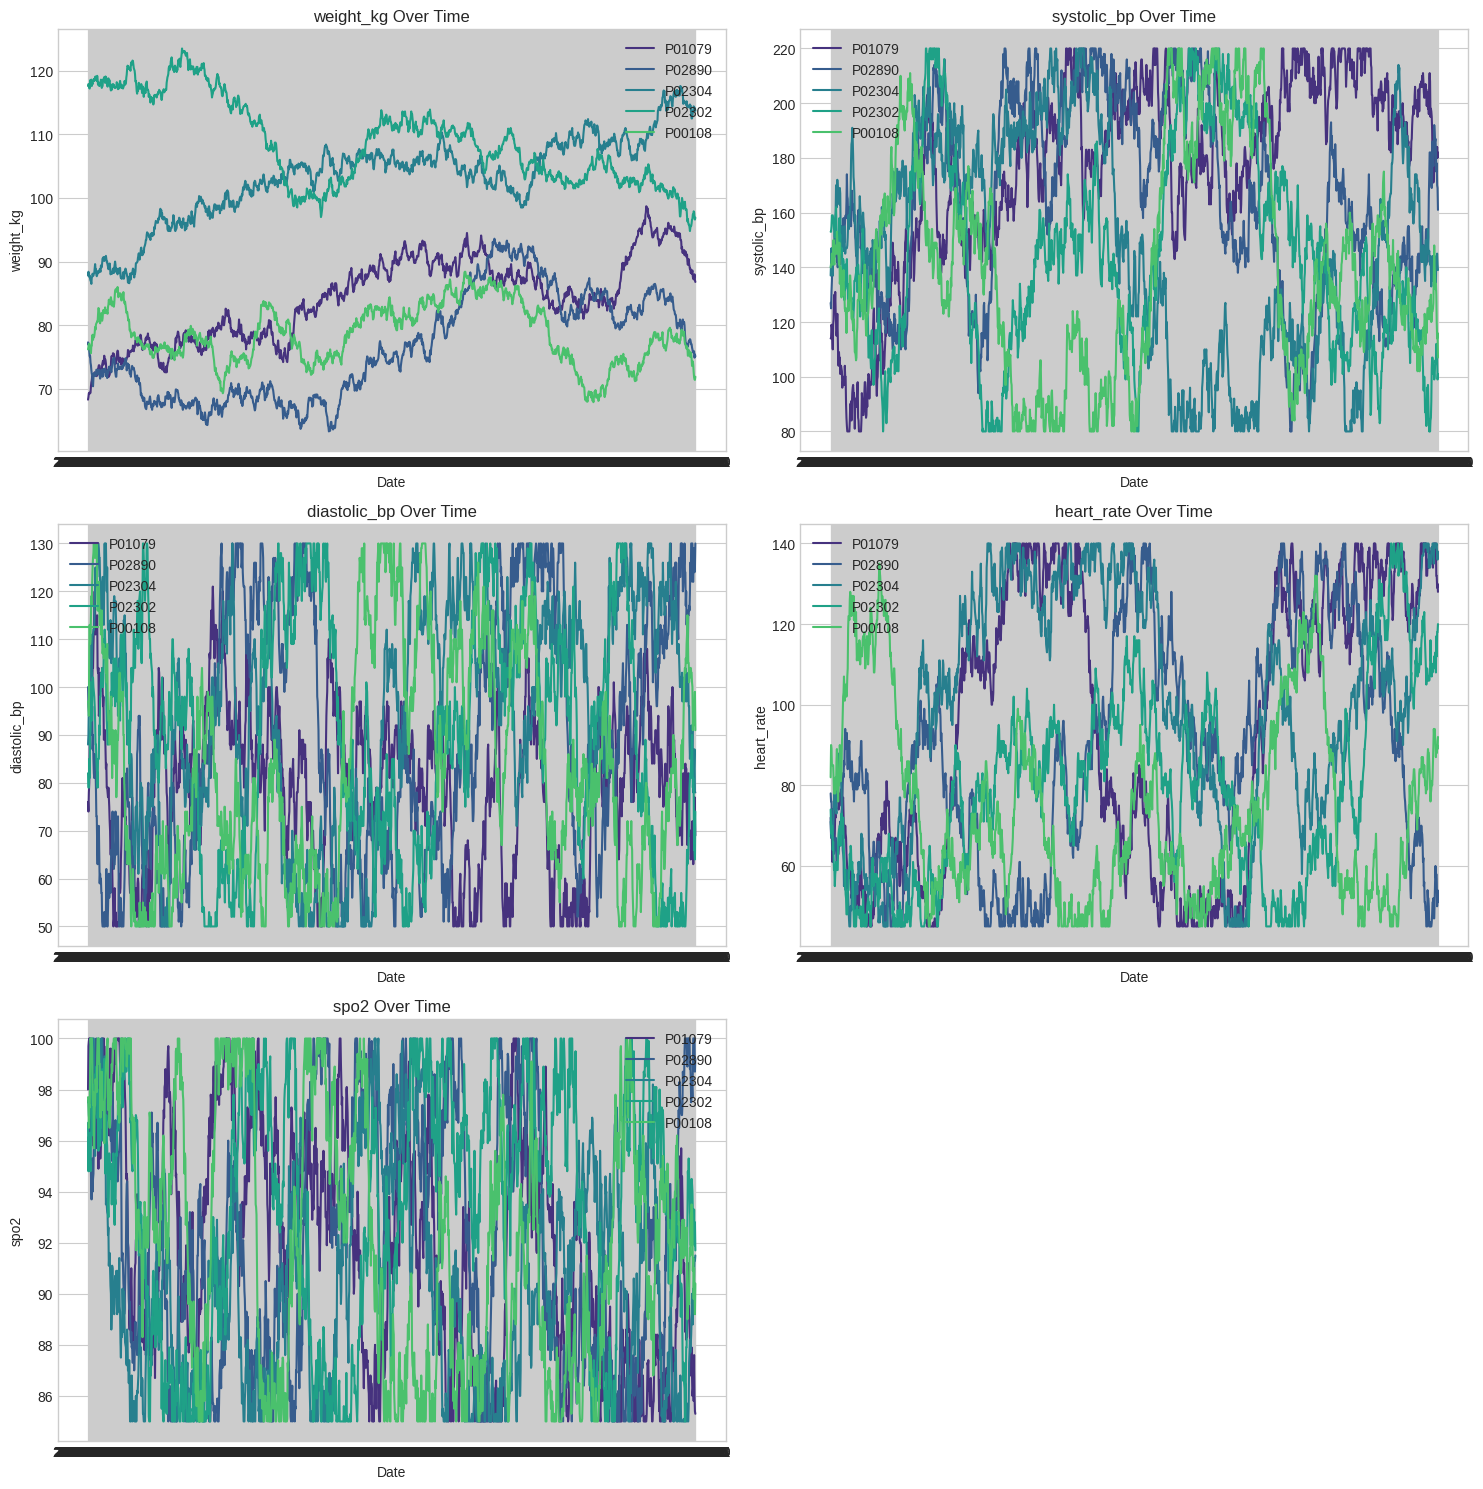

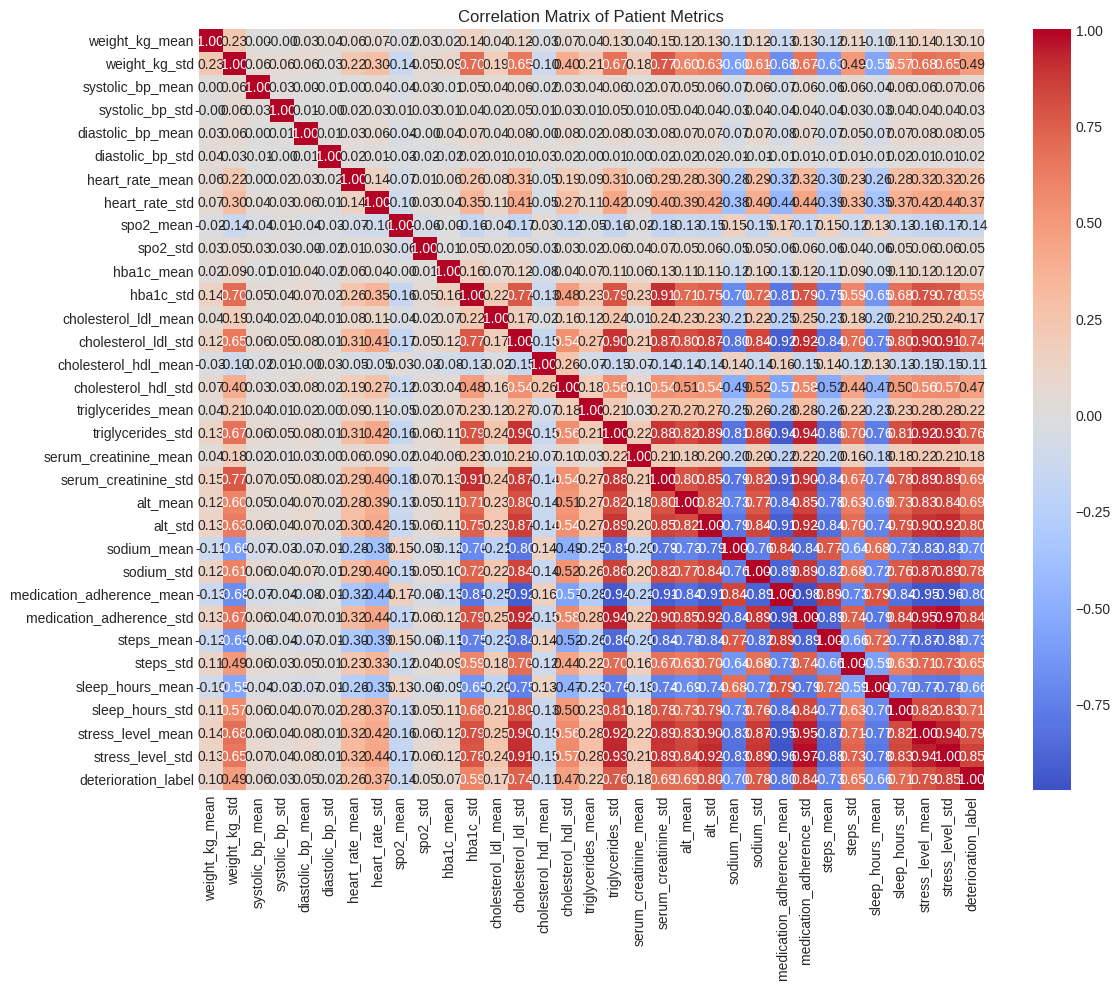

Analyzing lab values distribution...
hba1c: 7305000 non-null values
cholesterol_ldl: 7305000 non-null values
cholesterol_hdl: 7305000 non-null values
triglycerides: 7305000 non-null values
serum_creatinine: 7305000 non-null values
alt: 7305000 non-null values
sodium: 7305000 non-null values


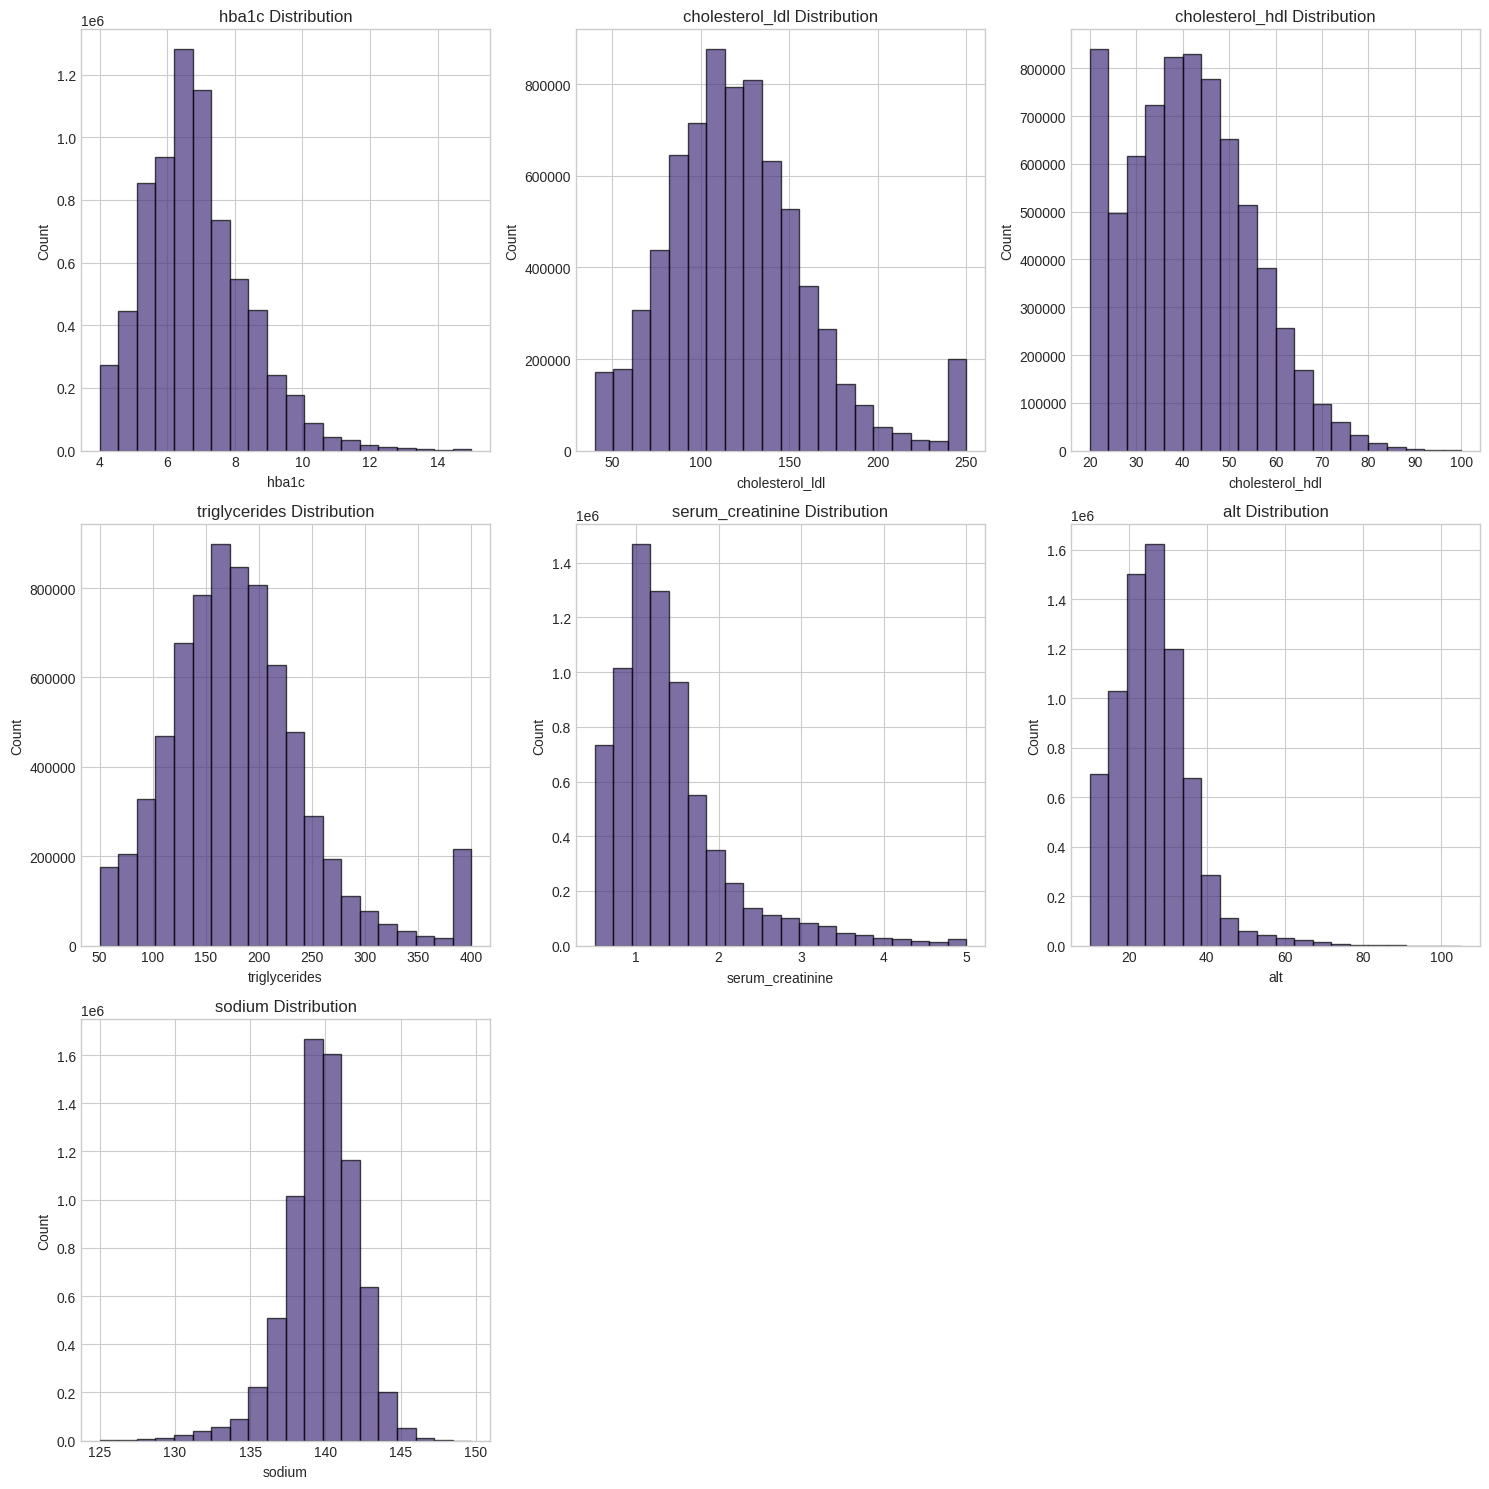

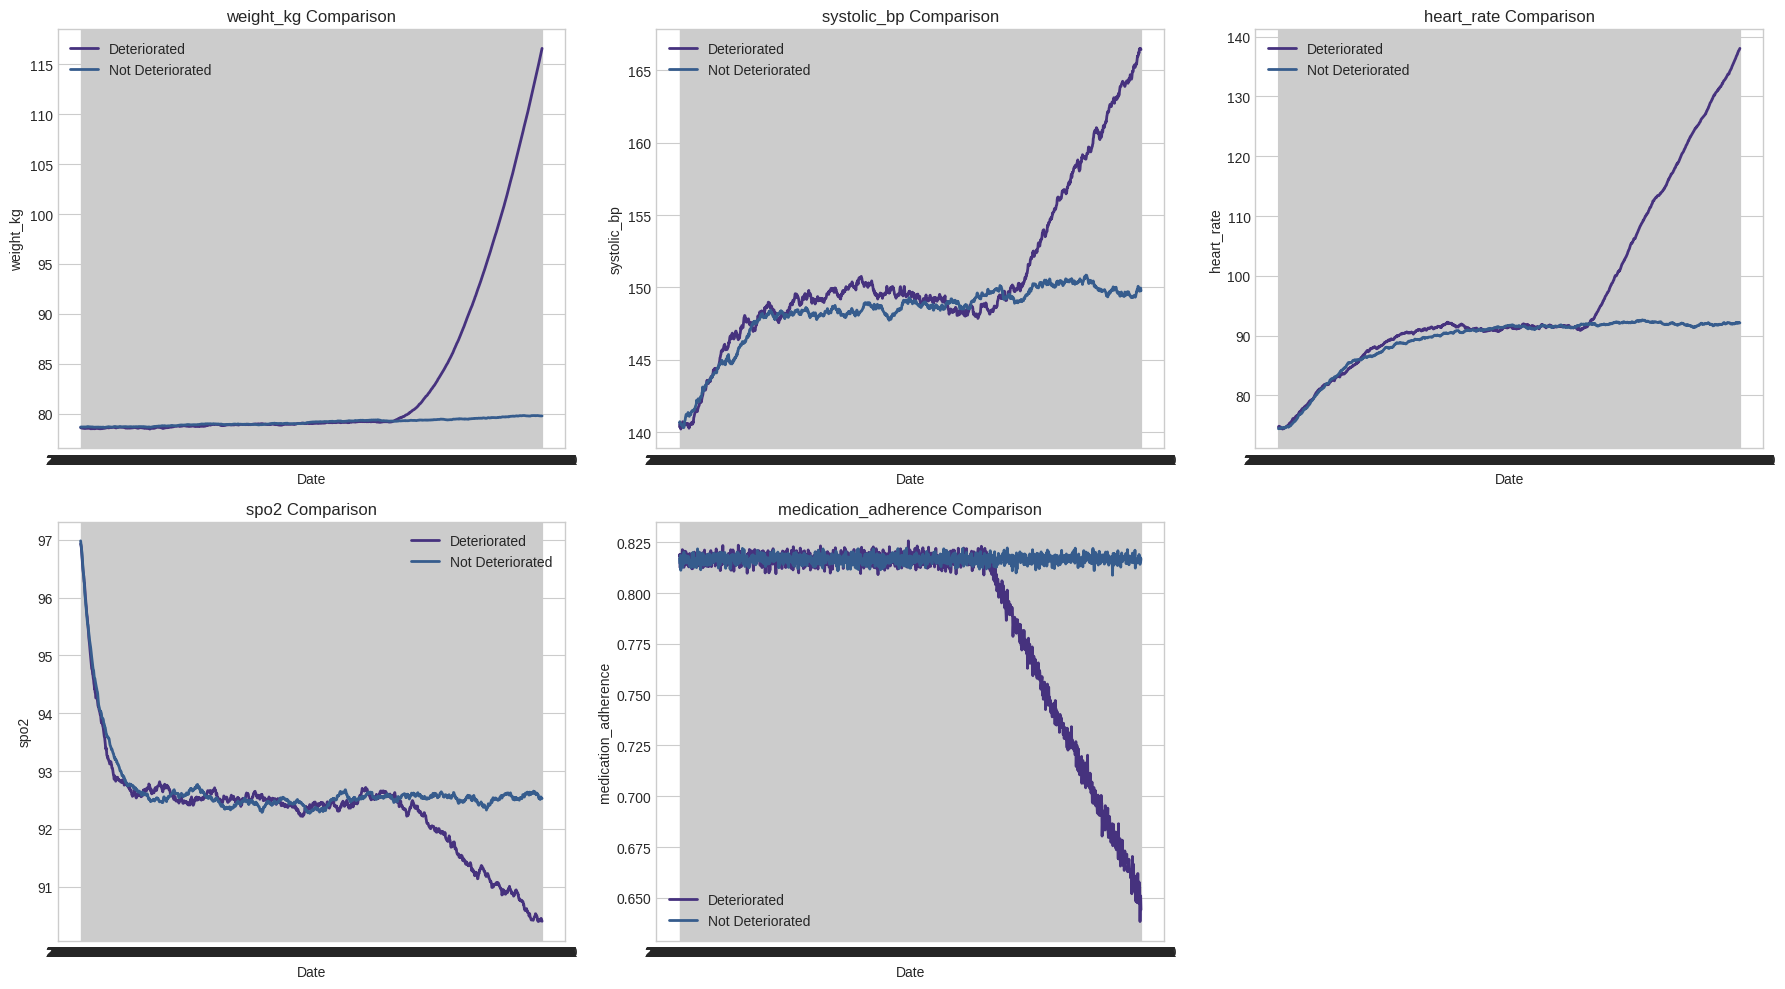

In [48]:
# ## Visualizations for Healthcare Data Analysis

# %%
print("Patient Demographics Overview:")
print(patients_df.describe())

# Create a subplot grid that adapts to available data
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Age distribution
if 'age' in patients_df.columns:
    axes[0, 0].hist(patients_df['age'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Age Distribution')
    axes[0, 0].set_xlabel('Age')
    axes[0, 0].set_ylabel('Count')
else:
    axes[0, 0].set_title('Age Data Not Available')
    axes[0, 0].set_axis_off()

# Gender distribution
if 'gender' in patients_df.columns and patients_df['gender'].notna().sum() > 0:
    gender_counts = patients_df['gender'].value_counts()
    axes[0, 1].pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%')
    axes[0, 1].set_title('Gender Distribution')
else:
    axes[0, 1].set_title('Gender Data Not Available')
    axes[0, 1].set_axis_off()

# Condition distribution
if 'condition' in patients_df.columns and patients_df['condition'].notna().sum() > 0:
    condition_counts = patients_df['condition'].value_counts()
    axes[0, 2].bar(condition_counts.index, condition_counts.values)
    axes[0, 2].set_title('Condition Distribution')
    axes[0, 2].tick_params(axis='x', rotation=45)
else:
    axes[0, 2].set_title('Condition Data Not Available')
    axes[0, 2].set_axis_off()

# BMI distribution
if 'baseline_bmi' in patients_df.columns and patients_df['baseline_bmi'].notna().sum() > 0:
    axes[1, 0].hist(patients_df['baseline_bmi'].dropna(), bins=20, edgecolor='black', alpha=0.7)
    axes[1, 0].set_title('BMI Distribution')
    axes[1, 0].set_xlabel('BMI')
    axes[1, 0].set_ylabel('Count')
else:
    axes[1, 0].set_title('BMI Data Not Available')
    axes[1, 0].set_axis_off()

# Smoking status
if 'smoking_status' in patients_df.columns and patients_df['smoking_status'].notna().sum() > 0:
    smoking_counts = patients_df['smoking_status'].value_counts()
    axes[1, 1].pie(smoking_counts.values, labels=smoking_counts.index, autopct='%1.1f%%')
    axes[1, 1].set_title('Smoking Status Distribution')
else:
    axes[1, 1].set_title('Smoking Data Not Available')
    axes[1, 1].set_axis_off()

# Outcome distribution
if not outcomes_df.empty and 'deterioration_label' in outcomes_df.columns:
    outcome_counts = outcomes_df['deterioration_label'].value_counts()
    axes[1, 2].pie(outcome_counts.values, labels=['No Deterioration', 'Deterioration'], autopct='%1.1f%%')
    axes[1, 2].set_title('Outcome Distribution')
else:
    axes[1, 2].set_title('Outcome Data Not Available')
    axes[1, 2].set_axis_off()

plt.tight_layout()
plt.show()

if not historical_df.empty:
    # Check which patients have data
    available_patients = historical_df['patient_id'].unique()
    if len(available_patients) > 0:
        sample_patients = np.random.choice(available_patients, min(5, len(available_patients)), replace=False)
        sample_data = historical_df[historical_df['patient_id'].isin(sample_patients)]

        # Check which vitals are available
        vitals_to_check = ['weight_kg', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'spo2']
        available_vitals = [vital for vital in vitals_to_check if vital in sample_data.columns and sample_data[vital].notna().sum() > 0]

        if available_vitals:
            # Create appropriate subplot grid
            rows = (len(available_vitals) + 1) // 2
            fig, axes = plt.subplots(rows, 2, figsize=(15, 5 * rows))

            if rows > 1:
                axes = axes.flatten()
            else:
                axes = [axes] if len(available_vitals) == 1 else axes

            for i, vital in enumerate(available_vitals):
                for patient in sample_patients:
                    patient_data = sample_data[sample_data['patient_id'] == patient]
                    if not patient_data.empty and vital in patient_data.columns and patient_data[vital].notna().sum() > 0:
                        axes[i].plot(patient_data['date'], patient_data[vital], label=patient)
                axes[i].set_title(f'{vital} Over Time')
                axes[i].set_xlabel('Date')
                axes[i].set_ylabel(vital)
                axes[i].legend()

            # Hide any unused subplots
            for i in range(len(available_vitals), len(axes)):
                axes[i].set_visible(False)

            plt.tight_layout()
            plt.show()
        else:
            print("No vital signs data available for visualization")
    else:
        print("No patient data available for visualization")
else:
    print("Historical data dataframe is empty")

# %%
# 3. Correlation analysis - FIXED
if not historical_df.empty and not outcomes_df.empty:
    # Prepare a dataset with mean values for each patient
    aggregation_dict = {}
    numeric_columns = historical_df.select_dtypes(include=[np.number]).columns

    for col in numeric_columns:
        if col != 'patient_id':  # Skip patient_id column
            aggregation_dict[col] = ['mean', 'std']

    patient_stats = historical_df.groupby('patient_id').agg(aggregation_dict).reset_index()

    # Flatten column names
    patient_stats.columns = ['_'.join(col).strip('_') for col in patient_stats.columns.values]
    patient_stats.rename(columns={'patient_id_': 'patient_id'}, inplace=True)

    # Merge with outcomes
    patient_stats = patient_stats.merge(outcomes_df[['patient_id', 'deterioration_label']], on='patient_id', how='left')

    # Calculate correlation matrix only with numeric columns
    numeric_stats = patient_stats.select_dtypes(include=[np.number])
    if not numeric_stats.empty:
        corr_matrix = numeric_stats.corr()

        # Plot correlation heatmap
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Correlation Matrix of Patient Metrics')
        plt.tight_layout()
        plt.show()
    else:
        print("No numeric data available for correlation analysis")
else:
    print("Insufficient data for correlation analysis")

print("Analyzing lab values distribution...")

# First, check which lab columns actually have data
lab_columns = ['hba1c', 'cholesterol_ldl', 'cholesterol_hdl', 'triglycerides', 'serum_creatinine', 'alt', 'sodium']
available_lab_columns = []

for col in lab_columns:
    if col in historical_df.columns and historical_df[col].notna().sum() > 0:
        available_lab_columns.append(col)
        print(f"{col}: {historical_df[col].notna().sum()} non-null values")
    else:
        print(f"{col}: No data available")

# Create appropriate subplot grid based on available data
num_labs = len(available_lab_columns)
if num_labs > 0:
    rows = (num_labs + 2) // 3  # Calculate rows needed (3 columns per row)
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    # Flatten axes array for easy iteration
    if rows > 1:
        axes = axes.flatten()
    else:
        axes = [axes] if num_labs == 1 else axes

    for i, lab in enumerate(available_lab_columns):
        lab_data = historical_df[lab].dropna()
        axes[i].hist(lab_data, bins=20, edgecolor='black', alpha=0.7)
        axes[i].set_title(f'{lab} Distribution')
        axes[i].set_xlabel(lab)
        axes[i].set_ylabel('Count')

    # Hide any unused subplots
    for i in range(len(available_lab_columns), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.show()
else:
    print("No lab data available for visualization")

if not historical_df.empty and not outcomes_df.empty:
    # Check if we have outcome data
    if 'deterioration_label' in outcomes_df.columns:
        deteriorated_patients = outcomes_df[outcomes_df['deterioration_label'] == 1]['patient_id']
        non_deteriorated_patients = outcomes_df[outcomes_df['deterioration_label'] == 0]['patient_id']

        deteriorated_data = historical_df[historical_df['patient_id'].isin(deteriorated_patients)]
        non_deteriorated_data = historical_df[historical_df['patient_id'].isin(non_deteriorated_patients)]

        # Check which metrics are available for comparison
        metrics_to_check = ['weight_kg', 'systolic_bp', 'heart_rate', 'spo2', 'medication_adherence']
        available_metrics = [metric for metric in metrics_to_check if metric in historical_df.columns and historical_df[metric].notna().sum() > 0]

        if available_metrics and not deteriorated_data.empty and not non_deteriorated_data.empty:
            # Calculate mean values over time for both groups
            deteriorated_means = deteriorated_data.groupby('date').mean(numeric_only=True)
            non_deteriorated_means = non_deteriorated_data.groupby('date').mean(numeric_only=True)

            # Create appropriate subplot grid
            rows = (len(available_metrics) + 2) // 3
            fig, axes = plt.subplots(rows, 3, figsize=(18, 5 * rows))

            if rows > 1:
                axes = axes.flatten()
            else:
                axes = [axes] if len(available_metrics) == 1 else axes

            for i, metric in enumerate(available_metrics):
                if metric in deteriorated_means.columns and metric in non_deteriorated_means.columns:
                    axes[i].plot(deteriorated_means.index, deteriorated_means[metric], label='Deteriorated', linewidth=2)
                    axes[i].plot(non_deteriorated_means.index, non_deteriorated_means[metric], label='Not Deteriorated', linewidth=2)
                    axes[i].set_title(f'{metric} Comparison')
                    axes[i].set_xlabel('Date')
                    axes[i].set_ylabel(metric)
                    axes[i].legend()

            # Hide any unused subplots
            for i in range(len(available_metrics), len(axes)):
                axes[i].set_visible(False)

            plt.tight_layout()
            plt.show()
        else:
            print("Insufficient data for trend comparison")
    else:
        print("No outcome data available for comparison")
else:
    print("Insufficient data for trend analysis")

In [47]:
print("Starting feature engineering...")
# For each patient, we'll create features from the 90 days before their index date
feature_data = []

for patient_id in tqdm(patients_df['patient_id'].unique()):
    patient_historical = historical_df[historical_df['patient_id'] == patient_id].copy()

    # Get patient outcome data and check if it exists
    patient_outcome_df = outcomes_df[outcomes_df['patient_id'] == patient_id]

    if patient_outcome_df.empty:
        # Skip patients with no outcome data
        continue

    patient_outcome = patient_outcome_df.iloc[0]

    # Ensure date columns are datetime objects
    patient_historical['date'] = pd.to_datetime(patient_historical['date'])
    index_date = pd.to_datetime(patient_outcome['index_date'])
    start_date = index_date - timedelta(days=90)

    # Filter to the 90-day window before index date
    window_data = patient_historical[
        (patient_historical['date'] >= start_date) &
        (patient_historical['date'] < index_date)
    ].copy()

    if len(window_data) == 0:
        continue

    # Get patient demographics
    patient_info = patients_df[patients_df['patient_id'] == patient_id].iloc[0]

    # Create features
    features = {
        'patient_id': patient_id,
        'age': patient_info['age'],
        'gender': patient_info['gender'],
        'condition': patient_info['condition'],
        'baseline_bmi': patient_info['baseline_bmi'],
        'smoking_status': patient_info['smoking_status'],
        'alcohol_status': patient_info['alcohol_status'],
        'activity_level': patient_info['activity_level'],
        'socioeconomic_status': patient_info['socioeconomic_status']
    }

    # Add comorbidities count
    if pd.notna(patient_info['comorbidities']):
        features['comorbidity_count'] = len(patient_info['comorbidities'].split('|'))
    else:
        features['comorbidity_count'] = 0

    # Vital trends and statistics
    for col in ['weight_kg', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'spo2']:
        if col in window_data.columns and not window_data[col].isnull().all():
            values = window_data[col].dropna()
            if len(values) > 1:
                # Calculate slope (trend)
                x = np.arange(len(values))
                slope = np.polyfit(x, values, 1)[0]
                features[f'{col}_slope'] = slope

            # Statistics
            features[f'{col}_mean'] = values.mean()
            features[f'{col}_std'] = values.std()
            features[f'{col}_cv'] = values.std() / values.mean() if values.mean() > 0 else 0  # Coefficient of variation
            features[f'{col}_min'] = values.min()
            features[f'{col}_max'] = values.max()
            features[f'{col}_last'] = values.iloc[-1]

    # Lab values (use the last available value in the window and trends)
    for col in ['hba1c', 'cholesterol_ldl', 'cholesterol_hdl', 'triglycerides', 'serum_creatinine', 'alt', 'sodium']:
        if col in window_data.columns:
            # Get the last non-null value
            non_null = window_data[col].dropna()
            if len(non_null) > 0:
                features[f'{col}_last'] = non_null.iloc[-1]

                # Calculate trend if enough data points
                if len(non_null) > 3:
                    x = np.arange(len(non_null))
                    slope = np.polyfit(x, non_null.values, 1)[0]
                    features[f'{col}_slope'] = slope

    # Lifestyle factors
    for col in ['steps', 'sleep_hours', 'stress_level']:
        if col in window_data.columns:
            values = window_data[col].dropna()
            if len(values) > 0:
                features[f'{col}_mean'] = values.mean()
                features[f'{col}_std'] = values.std()

    # Medication adherence
    if 'medication_adherence' in window_data.columns:
        adherence = window_data['medication_adherence'].dropna()
        if len(adherence) > 0:
            features['adherence_mean'] = adherence.mean()
            features['adherence_std'] = adherence.std()
            features['adherence_min'] = adherence.min()

    # Add the label
    features['deterioration_label'] = patient_outcome['deterioration_label']

    feature_data.append(features)

Starting feature engineering...


100%|██████████| 5000/5000 [47:59<00:00,  1.74it/s]


In [49]:
# Create feature dataframe
feature_df = pd.DataFrame(feature_data)
print(f"Feature engineering complete! Created {len(feature_df)} samples with {len(feature_df.columns)} features.")

Feature engineering complete! Created 5000 samples with 69 features.


In [50]:
# Handle missing values (median imputation for numeric columns)
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    if col != 'deterioration_label':  # Don't impute the label
        feature_df[col] = feature_df[col].fillna(feature_df[col].median())

In [51]:
# Convert categorical variables to dummy variables
categorical_cols = ['gender', 'condition', 'smoking_status', 'alcohol_status', 'activity_level', 'socioeconomic_status']
feature_df = pd.get_dummies(feature_df, columns=categorical_cols)

In [52]:
# Prepare data for modeling
X = feature_df.drop(['patient_id', 'deterioration_label'], axis=1)
y = feature_df['deterioration_label']

In [53]:
# Time-based split (use earlier patients for training, later for testing)
feature_df = feature_df.sort_values('patient_id')
split_idx = int(len(feature_df) * 0.7)  # 70% for training

X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Positive cases in test set: {y_test.sum()} ({y_test.mean()*100:.1f}%)")

Training set: 3500 samples
Test set: 1500 samples
Positive cases in test set: 493 (32.9%)


In [54]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
# Save feature names for later
feature_names = X.columns.tolist()

In [56]:
print("Training XGBoost model...")

# Define the model
model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum(),  # Handle class imbalance
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    eval_metric='aucpr'
)

# Train the model
model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict(X_test_scaled)

print("Model training complete!")


Training XGBoost model...
Model training complete!


In [57]:
print("\n=== MODEL EVALUATION ===")

# AUROC
auroc = roc_auc_score(y_test, y_pred_proba)
print(f"AUROC: {auroc:.4f}")

# AUPRC
auprc = average_precision_score(y_test, y_pred_proba)
print(f"AUPRC: {auprc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




=== MODEL EVALUATION ===
AUROC: 0.9262
AUPRC: 0.9278

Confusion Matrix:
[[1006    1]
 [  81  412]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1007
           1       1.00      0.84      0.91       493

    accuracy                           0.95      1500
   macro avg       0.96      0.92      0.94      1500
weighted avg       0.95      0.95      0.94      1500



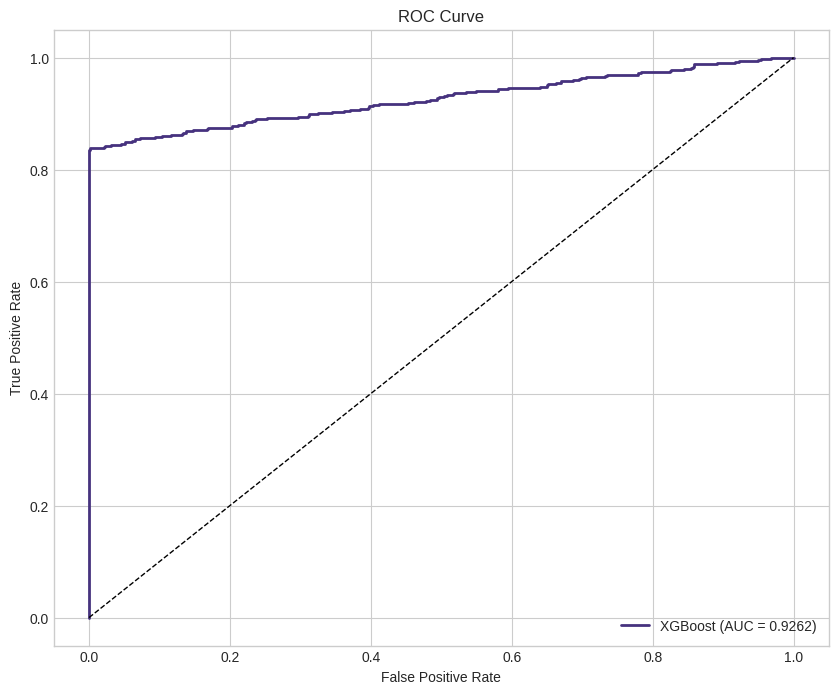

In [58]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auroc:.4f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

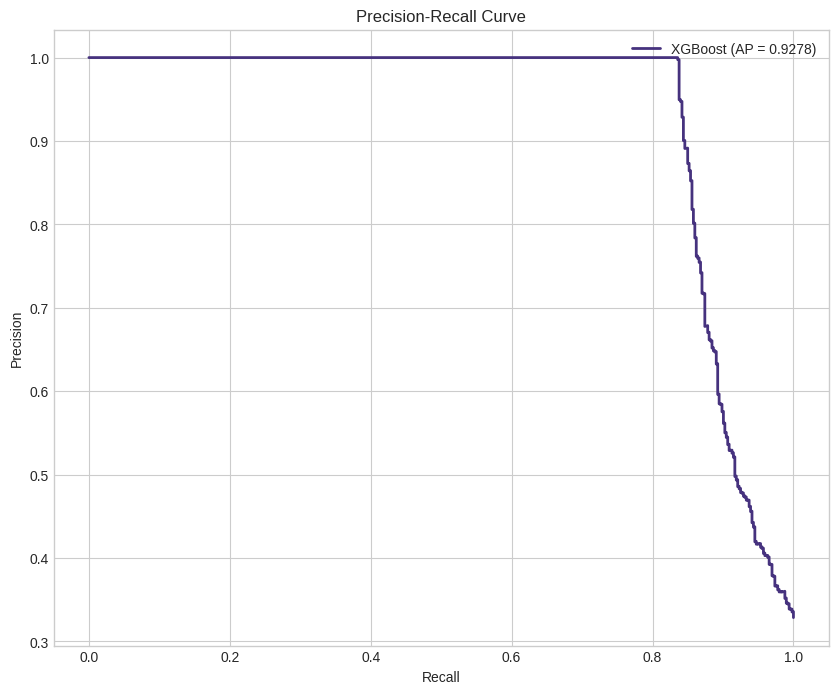

In [59]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, label=f'XGBoost (AP = {auprc:.4f})', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

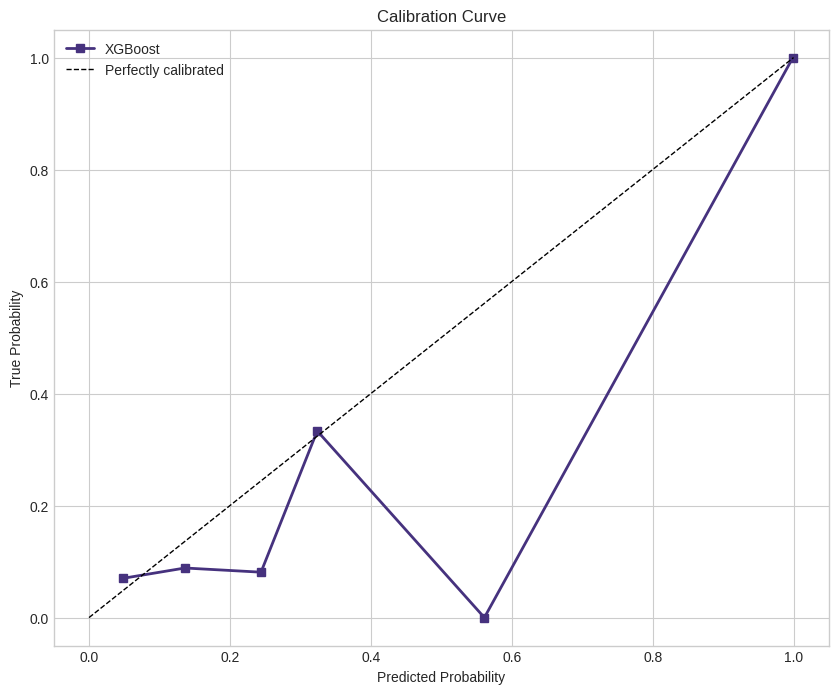

In [60]:
# Plot Calibration Curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(10, 8))
plt.plot(prob_pred, prob_true, 's-', label='XGBoost', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated', linewidth=1)
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

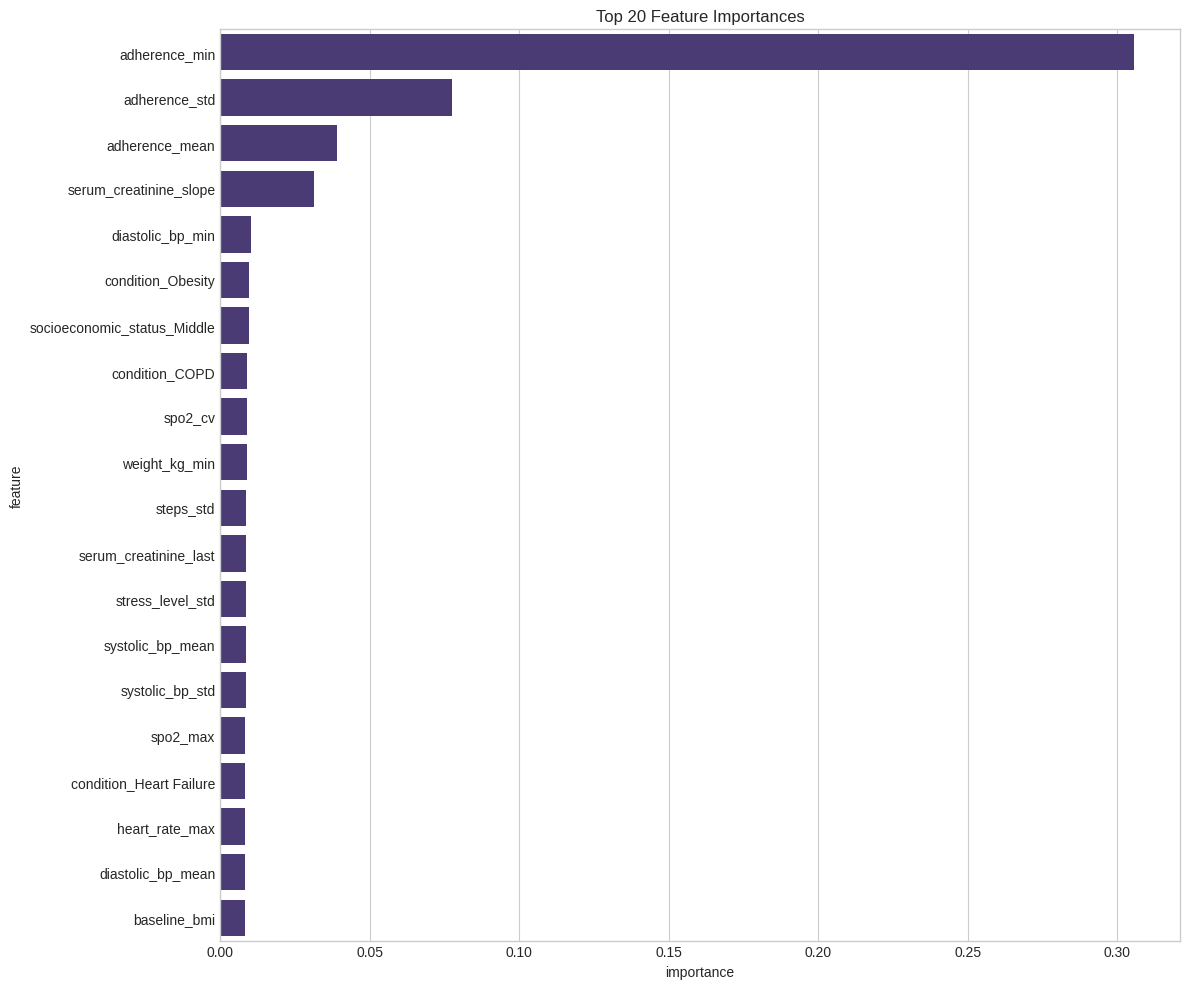

In [61]:
# Plot feature importance
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=importances.head(20))
plt.title('Top 20 Feature Importances')
plt.tight_layout()
plt.show()

Generating SHAP explanations...


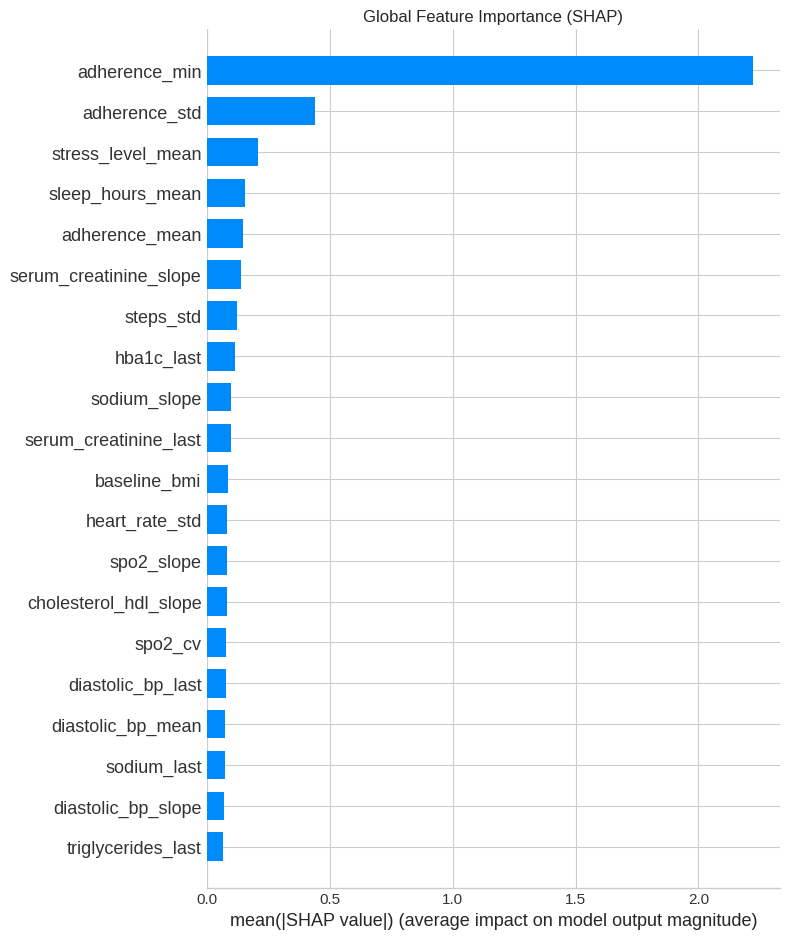

In [62]:
# SHAP Explainability
print("Generating SHAP explanations...")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)

# Global feature importance
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, plot_type="bar", show=False)
plt.title("Global Feature Importance (SHAP)")
plt.tight_layout()
plt.savefig('global_shap_importance.png', dpi=300, bbox_inches='tight')
plt.show()

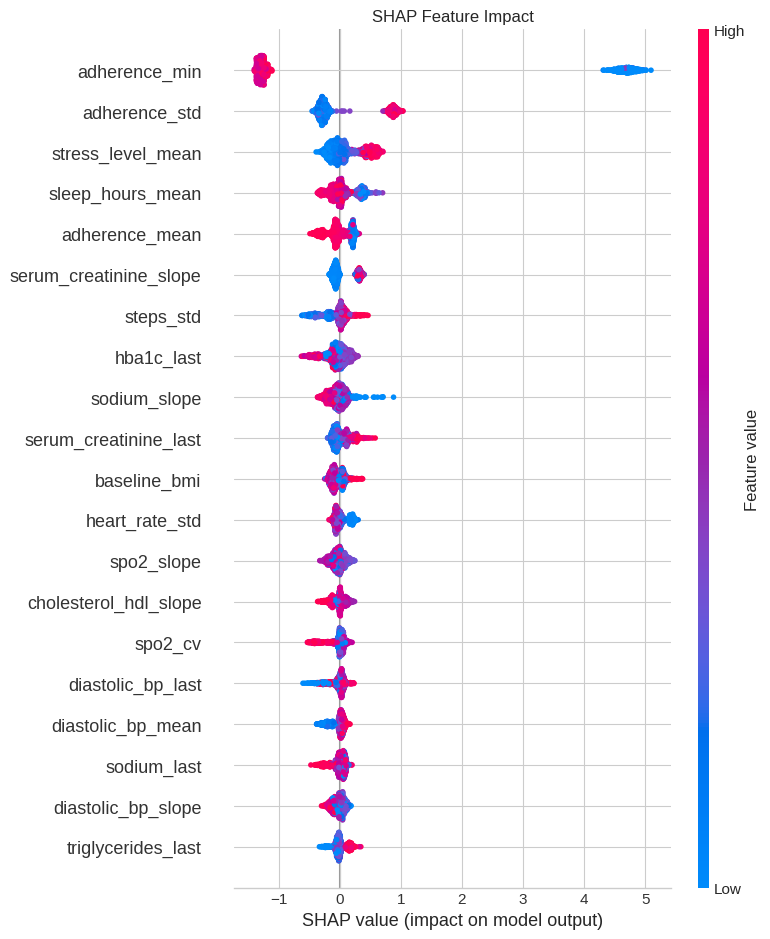

In [63]:
# SHAP summary plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.title("SHAP Feature Impact")
plt.tight_layout()
plt.savefig('shap_summary.png', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# Local explanation for a specific high-risk patient
high_risk_idx = np.argmax(y_pred_proba)
print(f"\nLocal explanation for patient with highest risk score ({y_pred_proba[high_risk_idx]:.2%})")


Local explanation for patient with highest risk score (99.97%)


<Figure size 1200x600 with 0 Axes>

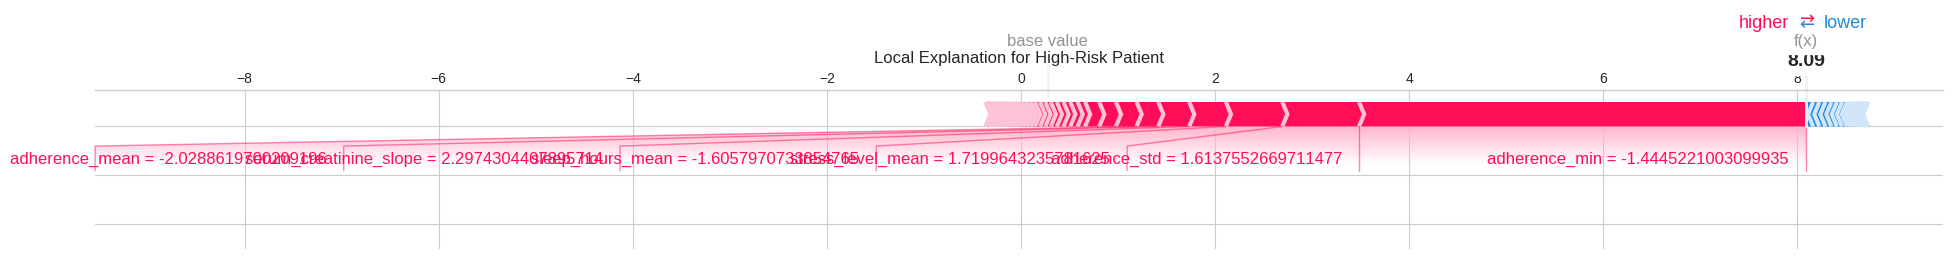

In [65]:
plt.figure(figsize=(12, 6))
shap.force_plot(
    explainer.expected_value,
    shap_values[high_risk_idx,:],
    X_test_scaled[high_risk_idx,:],
    feature_names=feature_names,
    matplotlib=True,
    show=False
)
plt.title(f"Local Explanation for High-Risk Patient")
plt.tight_layout()
plt.savefig('local_shap_explanation.png', dpi=300, bbox_inches='tight')
plt.show()

In [66]:
# Generate clinician-friendly explanations
def generate_clinician_explanation(patient_data, model, scaler, feature_names, explainer, top_n=5):
    """Generate clinician-friendly explanation for a patient's risk prediction"""

    # Scale the patient data
    patient_scaled = scaler.transform(patient_data.values.reshape(1, -1))

    # Get prediction
    pred_proba = model.predict_proba(patient_scaled)[0, 1]

    # Get SHAP values
    shap_vals = explainer.shap_values(patient_scaled)

    # Get top contributing features
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'shap_value': shap_vals[0]
    }).sort_values('shap_value', key=abs, ascending=False)

    # Get top positive and negative contributors
    top_positive = feature_importance[feature_importance['shap_value'] > 0].head(top_n)
    top_negative = feature_importance[feature_importance['shap_value'] < 0].head(top_n)

    # Generate explanation text
    explanation = f"Patient risk score: {pred_proba:.1%}\n\n"
    explanation += "Top factors increasing risk:\n"
    for _, row in top_positive.iterrows():
        explanation += f"- {row['feature']}: +{row['shap_value']:.3f}\n"

    explanation += "\nTop factors decreasing risk:\n"
    for _, row in top_negative.iterrows():
        explanation += f"- {row['feature']}: {row['shap_value']:.3f}\n"

    return explanation


In [67]:
# Test with a high-risk patient
high_risk_patient = X_test.iloc[high_risk_idx]
clinician_explanation = generate_clinician_explanation(high_risk_patient, model, scaler, feature_names, explainer)
print("Clinician-friendly explanation:")
print(clinician_explanation)

Clinician-friendly explanation:
Patient risk score: 100.0%

Top factors increasing risk:
- adherence_min: +4.607
- adherence_std: +0.791
- stress_level_mean: +0.582
- sleep_hours_mean: +0.378
- serum_creatinine_slope: +0.319

Top factors decreasing risk:
- hba1c_last: -0.073
- steps_mean: -0.064
- cholesterol_ldl_last: -0.063
- spo2_mean: -0.062
- weight_kg_slope: -0.057



In [68]:
patient_predictions = pd.DataFrame({
    'patient_id': feature_df['patient_id'].iloc[split_idx:].values,
    'risk_score': y_pred_proba
})

In [69]:
# Merge with patient information
dashboard_data = patients_df.merge(patient_predictions, on='patient_id')
dashboard_data = dashboard_data.merge(outcomes_df[['patient_id', 'deterioration_label']], on='patient_id')

In [70]:
# Create risk categories
dashboard_data['risk_category'] = pd.cut(
    dashboard_data['risk_score'],
    bins=[0, 0.2, 0.4, 0.6, 0.8, 1.0],
    labels=['Very Low', 'Low', 'Medium', 'High', 'Very High']
)

In [71]:
# Save dashboard data
dashboard_data.to_csv('dashboard_data.csv', index=False)
print("Dashboard data saved!")

Dashboard data saved!


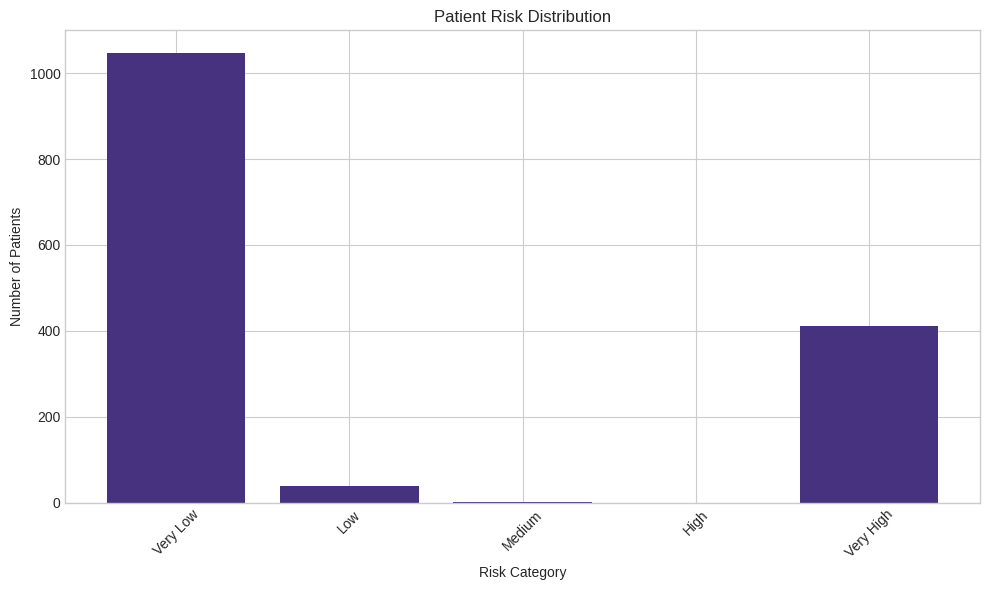

In [72]:
# 1. Risk distribution
plt.figure(figsize=(10, 6))
risk_counts = dashboard_data['risk_category'].value_counts().sort_index()
plt.bar(risk_counts.index, risk_counts.values)
plt.title('Patient Risk Distribution')
plt.xlabel('Risk Category')
plt.ylabel('Number of Patients')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('risk_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

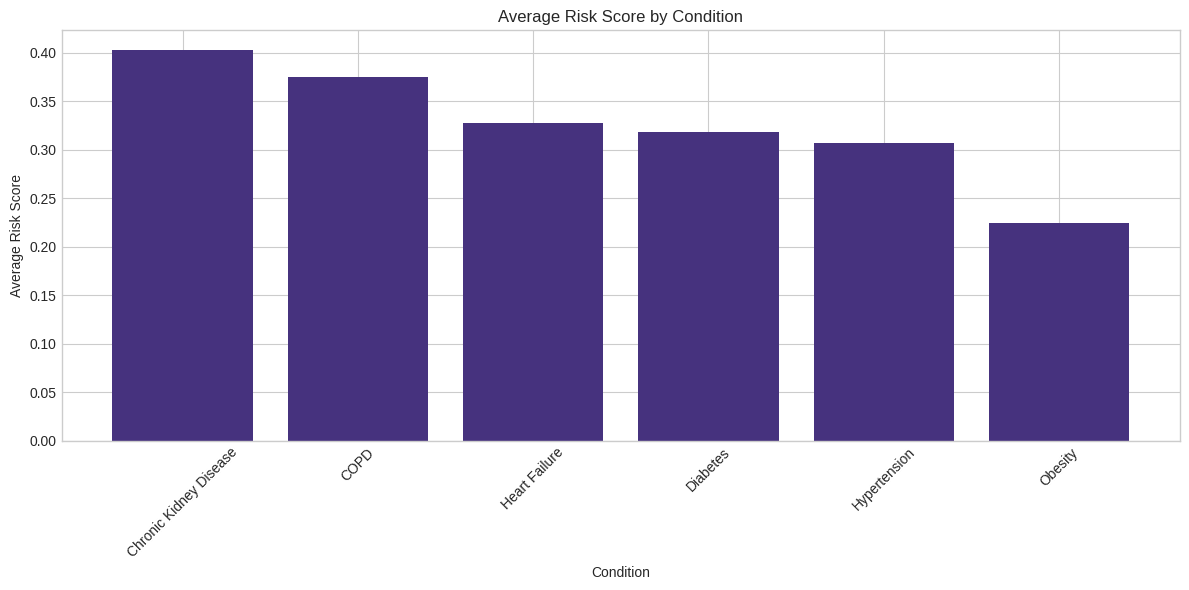

In [73]:
# 2. Risk by condition
plt.figure(figsize=(12, 6))
condition_risk = dashboard_data.groupby('condition')['risk_score'].mean().sort_values(ascending=False)
plt.bar(condition_risk.index, condition_risk.values)
plt.title('Average Risk Score by Condition')
plt.xlabel('Condition')
plt.ylabel('Average Risk Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('risk_by_condition.png', dpi=300, bbox_inches='tight')
plt.show()

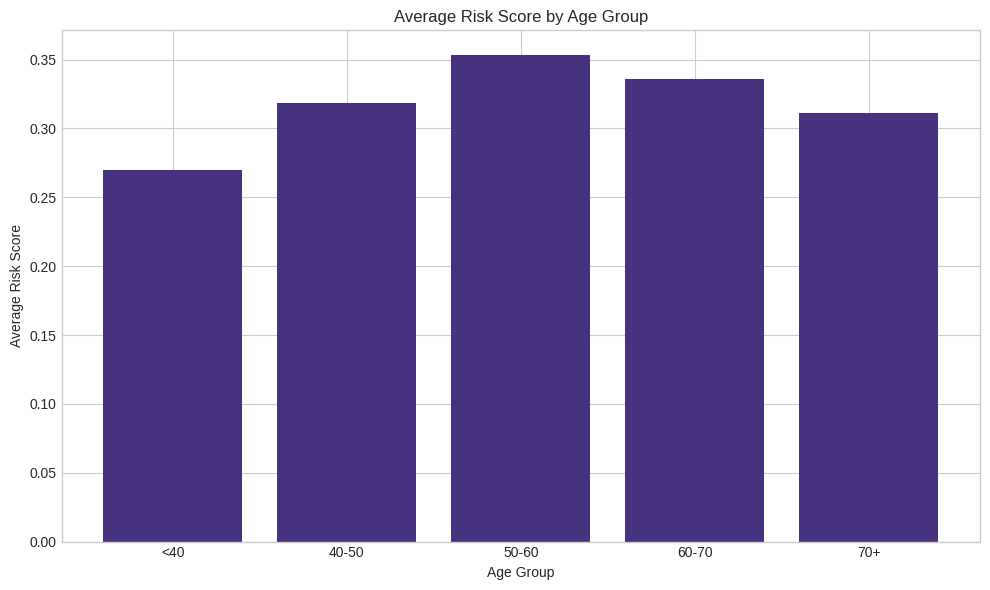

In [74]:
# 3. Risk by age group
dashboard_data['age_group'] = pd.cut(dashboard_data['age'], bins=[0, 40, 50, 60, 70, 100], labels=['<40', '40-50', '50-60', '60-70', '70+'])
age_risk = dashboard_data.groupby('age_group')['risk_score'].mean()
plt.figure(figsize=(10, 6))
plt.bar(age_risk.index, age_risk.values)
plt.title('Average Risk Score by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Risk Score')
plt.tight_layout()
plt.savefig('risk_by_age.png', dpi=300, bbox_inches='tight')
plt.show()

In [75]:
print("Saving model and artifacts...")
# Save model
joblib.dump(model, 'risk_prediction_model.pkl')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(feature_names, f)

# Save SHAP explainer
joblib.dump(explainer, 'shap_explainer.pkl')

# Save evaluation metrics
metrics = {
    'auroc': auroc,
    'auprc': auprc,
    'confusion_matrix': cm.tolist()
}

with open('model_metrics.json', 'w') as f:
    json.dump(metrics, f)

print("All artifacts saved successfully!")

Saving model and artifacts...
All artifacts saved successfully!


In [76]:
# Generate clinical recommendations based on risk factors
def generate_recommendations(patient_data, top_features=3):
    """Generate clinical recommendations based on top risk factors"""

    recommendations = []

    # Check weight trends
    if 'weight_kg_slope' in patient_data and patient_data['weight_kg_slope'] > 0.1:
        recommendations.append("Consider weight management intervention due to increasing weight trend")

    # Check blood pressure
    if 'systolic_bp_last' in patient_data and patient_data['systolic_bp_last'] > 140:
        recommendations.append("Elevated systolic blood pressure detected - consider medication adjustment")

    # Check HbA1c
    if 'hba1c_last' in patient_data and patient_data['hba1c_last'] > 7.0:
        recommendations.append("Elevated HbA1c detected - consider diabetes management review")

    # Check medication adherence
    if 'adherence_mean' in patient_data and patient_data['adherence_mean'] < 0.8:
        recommendations.append("Low medication adherence detected - consider adherence counseling")

    # Check activity level
    if 'steps_mean' in patient_data and patient_data['steps_mean'] < 5000:
        recommendations.append("Low activity level detected - consider physical activity promotion")

    # If no specific issues found, provide general recommendations
    if not recommendations:
        recommendations.append("Continue current management plan with regular monitoring")

    return recommendations


In [77]:
# Test with a patient
sample_patient = X_test.iloc[high_risk_idx]
recs = generate_recommendations(sample_patient)
print("Clinical recommendations for high-risk patient:")
for i, rec in enumerate(recs, 1):
    print(f"{i}. {rec}")

Clinical recommendations for high-risk patient:
1. Consider weight management intervention due to increasing weight trend
2. Elevated systolic blood pressure detected - consider medication adjustment
3. Elevated HbA1c detected - consider diabetes management review
4. Low medication adherence detected - consider adherence counseling
5. Low activity level detected - consider physical activity promotion


In [78]:
# Print final summary
print("="*50)
print("AI-DRIVEN RISK PREDICTION ENGINE - SUMMARY")
print("="*50)
print(f"Patients analyzed: {len(patients_df)}")
print(f"Time-series data points: {len(historical_df)}")
print(f"Features engineered: {len(feature_names)}")
print(f"Model performance - AUROC: {auroc:.4f}, AUPRC: {auprc:.4f}")
print(f"High-risk patients identified: {len(dashboard_data[dashboard_data['risk_score'] > 0.6])}")
print("="*50)
print("Key risk factors identified:")
for i, feature in enumerate(importances['feature'].head(5).tolist(), 1):
    print(f"{i}. {feature}")
print("="*50)


AI-DRIVEN RISK PREDICTION ENGINE - SUMMARY
Patients analyzed: 5000
Time-series data points: 7305000
Features engineered: 82
Model performance - AUROC: 0.9262, AUPRC: 0.9278
High-risk patients identified: 412
Key risk factors identified:
1. adherence_min
2. adherence_std
3. adherence_mean
4. serum_creatinine_slope
5. diastolic_bp_min
